In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [11]:
df = pd.read_csv('Data/movies_tableau_V3.csv')

Quick check of the relationship between some of the numeric variables in DF:

In [12]:
df.corr(numeric_only=True)

,budget,domestic_revenue,world_revenue,year,isAdult,startYear,averageRating,numVotes
budget,1.000000,0.683269,0.735739,0.216806,-0.009681,0.190948,0.026970,0.379888
domestic_revenue,0.683269,1.000000,0.942330,0.071537,-0.000062,0.059328,0.169823,0.528997
world_revenue,0.735739,0.942330,1.000000,0.129769,-0.003701,0.115483,0.166862,0.511019
year,0.216806,0.071537,0.129769,1.000000,-0.032476,0.886654,-0.114854,0.002709
isAdult,-0.009681,-0.000062,-0.003701,-0.032476,1.000000,-0.034139,-0.019318,-0.006374
startYear,0.190948,0.059328,0.115483,0.886654,-0.034139,1.000000,-0.049130,-0.042764
averageRating,0.026970,0.169823,0.166862,-0.114854,-0.019318,-0.049130,1.000000,0.354898
numVotes,0.379888,0.528997,0.511019,0.002709,-0.006374,-0.042764,0.354898,1.000000


There are some redundant columns in this data set. Dropping those before proceeding:

In [13]:
df = df.drop(columns='startYear')

Run time should be numeric. Changing data type:

In [14]:
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
#show new correlation matrix
df.corr(numeric_only=True)

,budget,domestic_revenue,world_revenue,year,isAdult,runtimeMinutes,averageRating,numVotes
budget,1.000000,0.683269,0.735739,0.216806,-0.009681,0.316943,0.026970,0.379888
domestic_revenue,0.683269,1.000000,0.942330,0.071537,-0.000062,0.273801,0.169823,0.528997
world_revenue,0.735739,0.942330,1.000000,0.129769,-0.003701,0.286364,0.166862,0.511019
year,0.216806,0.071537,0.129769,1.000000,-0.032476,-0.082436,-0.114854,0.002709
isAdult,-0.009681,-0.000062,-0.003701,-0.032476,1.000000,-0.032769,-0.019318,-0.006374
runtimeMinutes,0.316943,0.273801,0.286364,-0.082436,-0.032769,1.000000,0.394158,0.348231
averageRating,0.026970,0.169823,0.166862,-0.114854,-0.019318,0.394158,1.000000,0.354898
numVotes,0.379888,0.528997,0.511019,0.002709,-0.006374,0.348231,0.354898,1.000000


In [15]:
model_df = df.select_dtypes(include=['number'])

model.csv saved to data folder:

In [16]:
model_df.to_csv('model.csv',index=False)

Plot out histograms for each numeric value to get an idea of the distributions:

4


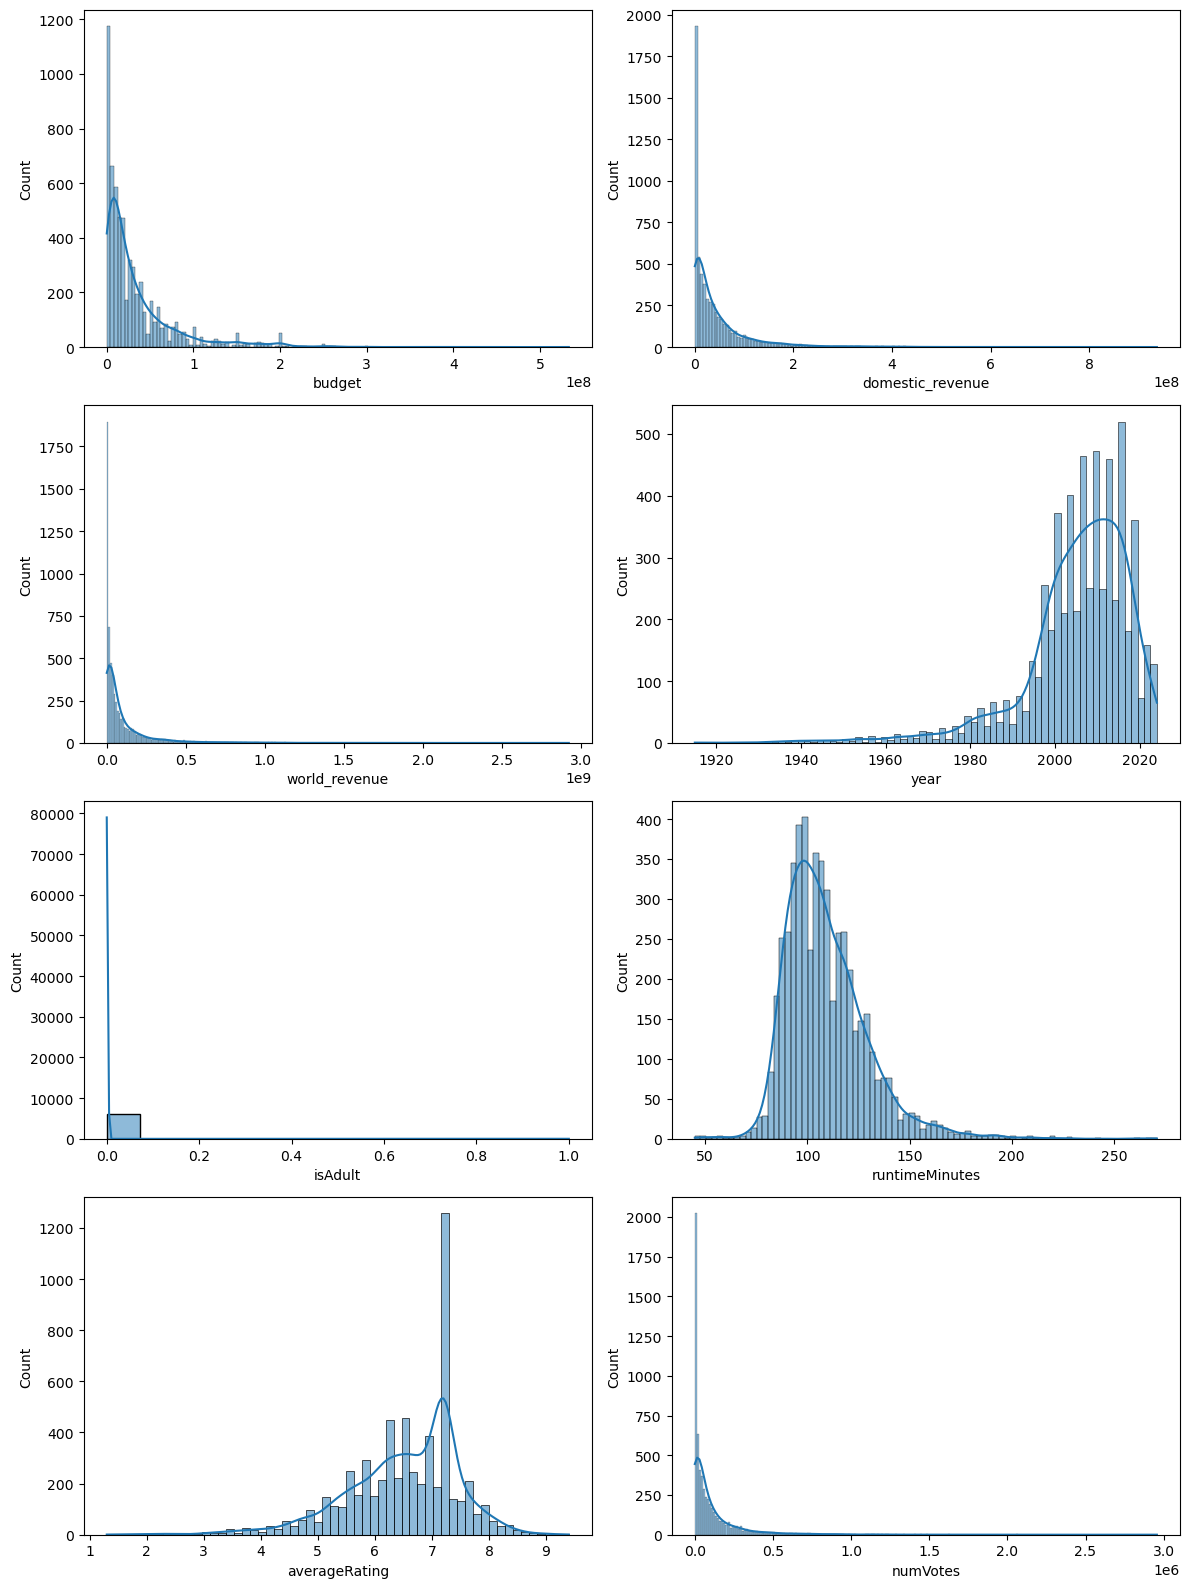

In [42]:
# Set up the grid
num_columns = len((model_df).columns)
cols = 2  # Number of columns in the grid
rows = (num_columns // cols) + (num_columns % cols > 0)  # Calculate rows needed
print(rows)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten to easily index

# build histograms
for i, column in enumerate((model_df).columns):
    sns.histplot(model_df[column], kde=True, ax=axes[i])

#show the resulting hist
plt.tight_layout()
plt.show()

isAdult seems to be a binary column and may be useful for categorical modeling. However that is not the aim of this project so I will drop that column:

In [4]:
model_df = pd.read_csv('Data/model.csv')

In [5]:
model_df = model_df.drop(columns='isAdult')

Checking correlations:

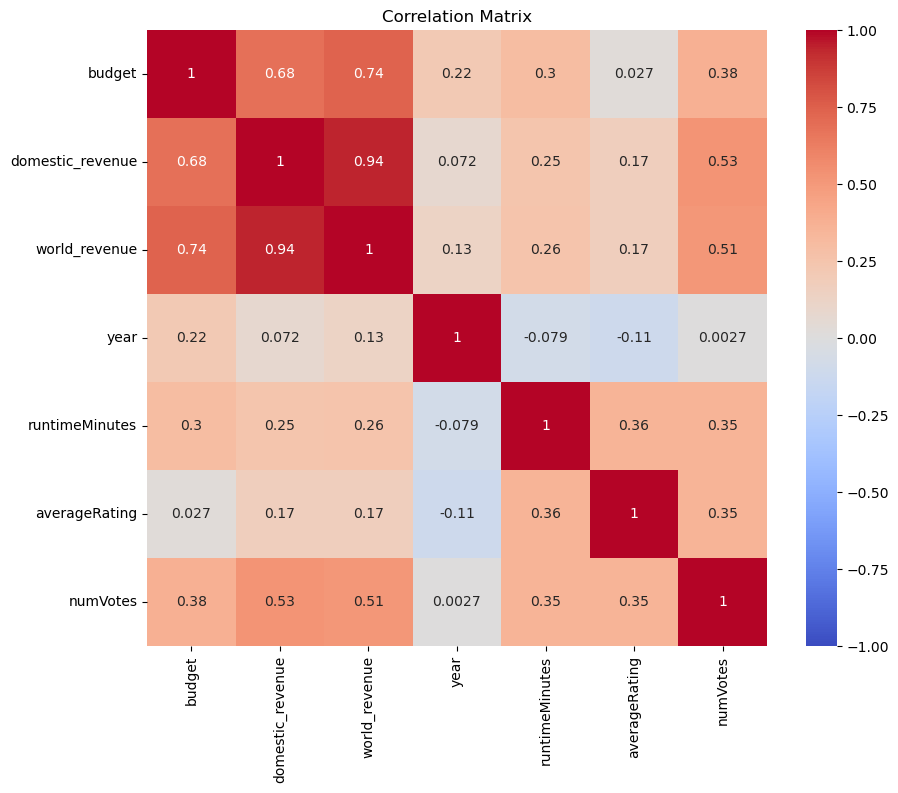

In [39]:
cor_matrix = model_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Domestic Revenue and World Revenue are very closely related. As I want to predict World revenue, I will drop domestic revenue in the model since they are too closely related. This high correlation could cause redundancy moving foward.

Now that we have seen the distribution and correlations of the values in this dataframe, lets try an initial model:

***Can we predict the world revenue of a movie based on the available numeric variables?***

In [31]:
model_df.isnull().sum()

budget              0
domestic_revenue    0
world_revenue       0
year                0
runtimeMinutes      0
averageRating       0
numVotes            0
dtype: int64

There are several nulls in the runtime column. As this makes up a significant portion of the data (~12%) I will impute these nulls with the median value from the column. From above, the runtime data is fairly normally distributed, so the median should be a viable option for imputing the nulls:

In [30]:
model_df['runtimeMinutes'] = model_df['runtimeMinutes'].fillna(df['runtimeMinutes'].median())

Setting up model for the dependent variable 'world_revenue' using all independant variables:

In [50]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','year','numVotes']]
X = sm.add_constant(X) 

model = sm.OLS(y, X) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1925.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:04:49   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6159   BIC:                         2.469e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.007e+08   2.47e+08      0.

Just realized that budget is massively larger than the rest of the columns. Normalizing data and running again:

In [72]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','year','numVotes']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1925.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:38:06   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6159   BIC:                         2.469e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08   1.53e+06     65.927      0.0

Dropping year from the independant variables as it has the lowest t-value, and a p-value above 0.05. After that, dropping variables resulted in a worse r-squared so the final model is as follows:

In [79]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','numVotes']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2406.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:49:19   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6160   BIC:                         2.469e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08   1.53e+06     65.927      0.0

Checking Residuals of model:

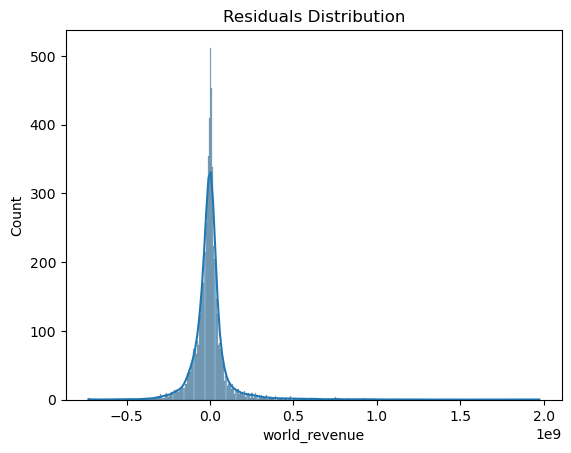

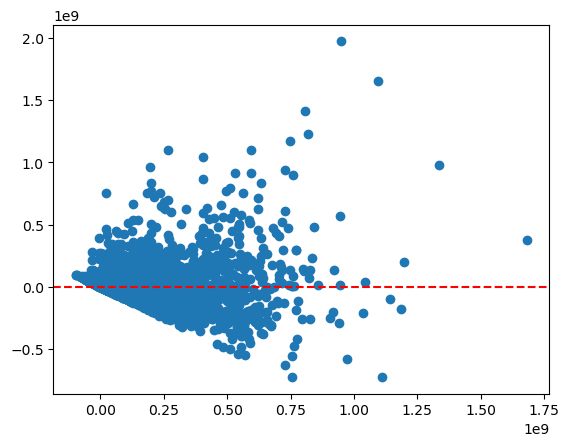

In [82]:
residuals = y - results.predict(X_scaled)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

plt.scatter(results.predict(X_scaled), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.show()

There is an issue with the above scatter plot. May be caused by inter-related variables or have something to do with the scaling. Need to review before re-attempting model

Checking for outliers in each column used in the above model and re-attempting:

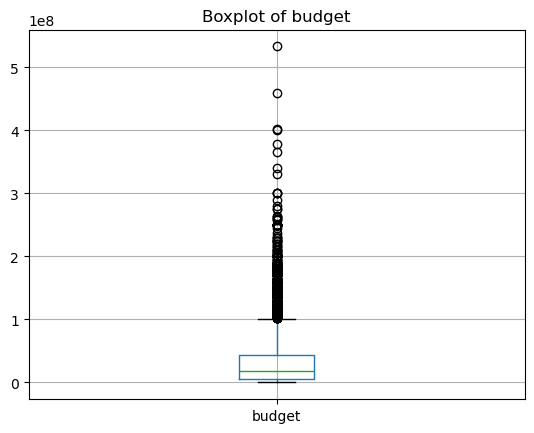

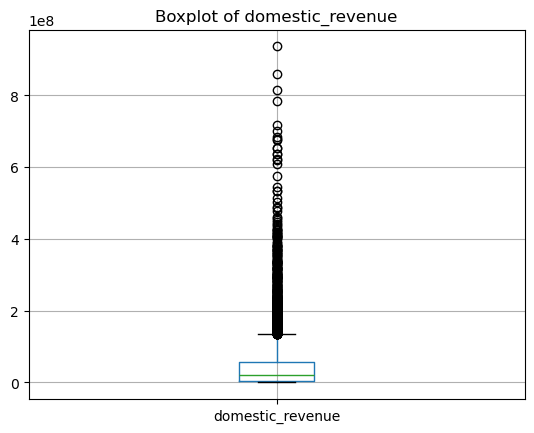

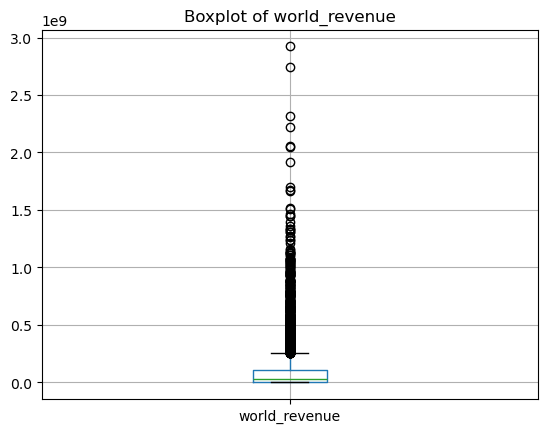

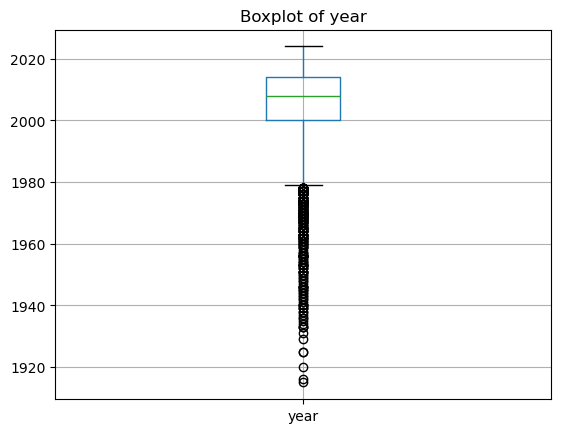

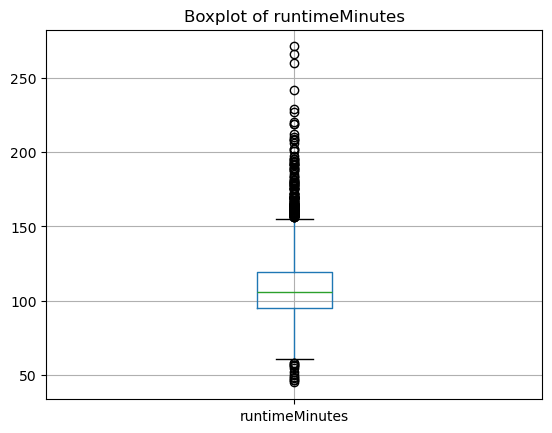

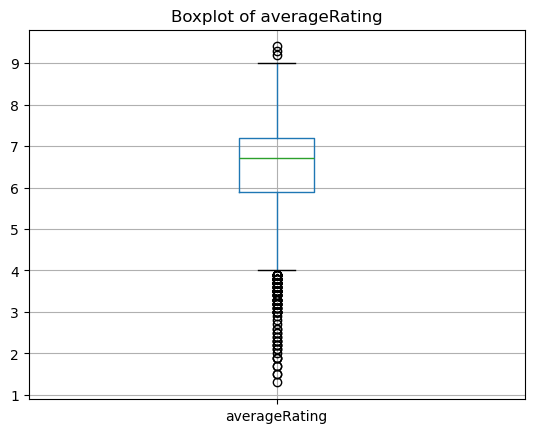

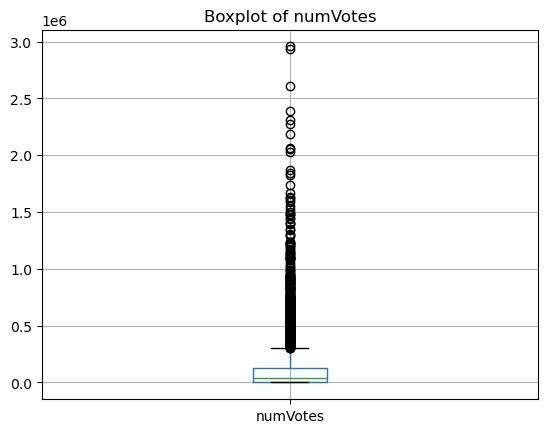

In [7]:
# Plot boxplots for each column
for column in model_df.columns:
    plt.figure()
    model_df.boxplot([column])
    plt.title(f'Boxplot of {column}')
    plt.show()

The boxplots indicate a large amount of outliers still present in our model's dataset. Using IQR below, we can see around 1400 rows are defined as outliers. This represents ~20% of our dataset. Further review needed before we can drop any of these data points. As we are trying to predict world revenue, an outlier in the budget category is something we may want to keep, for example.

In [8]:
# Calculate Q1 and Q3
Q1 = model_df.quantile(0.25)
Q3 = model_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((model_df < (Q1 - 1.5 * IQR)) | (model_df > (Q3 + 1.5 * IQR)))
outliers = model_df[outliers_iqr.any(axis=1)]
print(outliers)

          budget  domestic_revenue  world_revenue  year  runtimeMinutes  \
0      1455000.0         2620000.0      2620000.0  1968           113.0   
1      2500000.0        12300000.0     12300000.0  1971            98.0   
2      1800000.0         8800000.0      8800000.0  1973            93.0   
3     11000000.0        20000000.0     20221274.0  1975           185.0   
4      7000000.0        25000000.0     25000076.0  1976           119.0   
...          ...               ...            ...   ...             ...   
6155  25000000.0        13657115.0     24215385.0  2011           140.0   
6156  10000000.0         2529395.0      2529395.0  2011            97.0   
6157   3000000.0          508714.0       533235.0  2011            93.0   
6161  61000000.0        81697192.0    310566162.0  2015           131.0   
6163  15000000.0         2423467.0      3503761.0  2016            91.0   

      averageRating  numVotes  
0               5.6      3557  
1               6.3     42119  
2  

----Work In Progess----